<a href="https://colab.research.google.com/github/ShreyaJaiswal1604/Coursework-Advances-in-Data-Sciences-and-Architecture/blob/main/Assignments/02-03232024-Causality/02-Worked-Examples-Causality/Crash_Course_Causality_Worked_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"></h1>

---
---

# <center>**WORKED EXAMPLE 1**</center>

---

## <center>**Causal Analysis: Understanding Factors Influencing House Prices**</center>

---
---


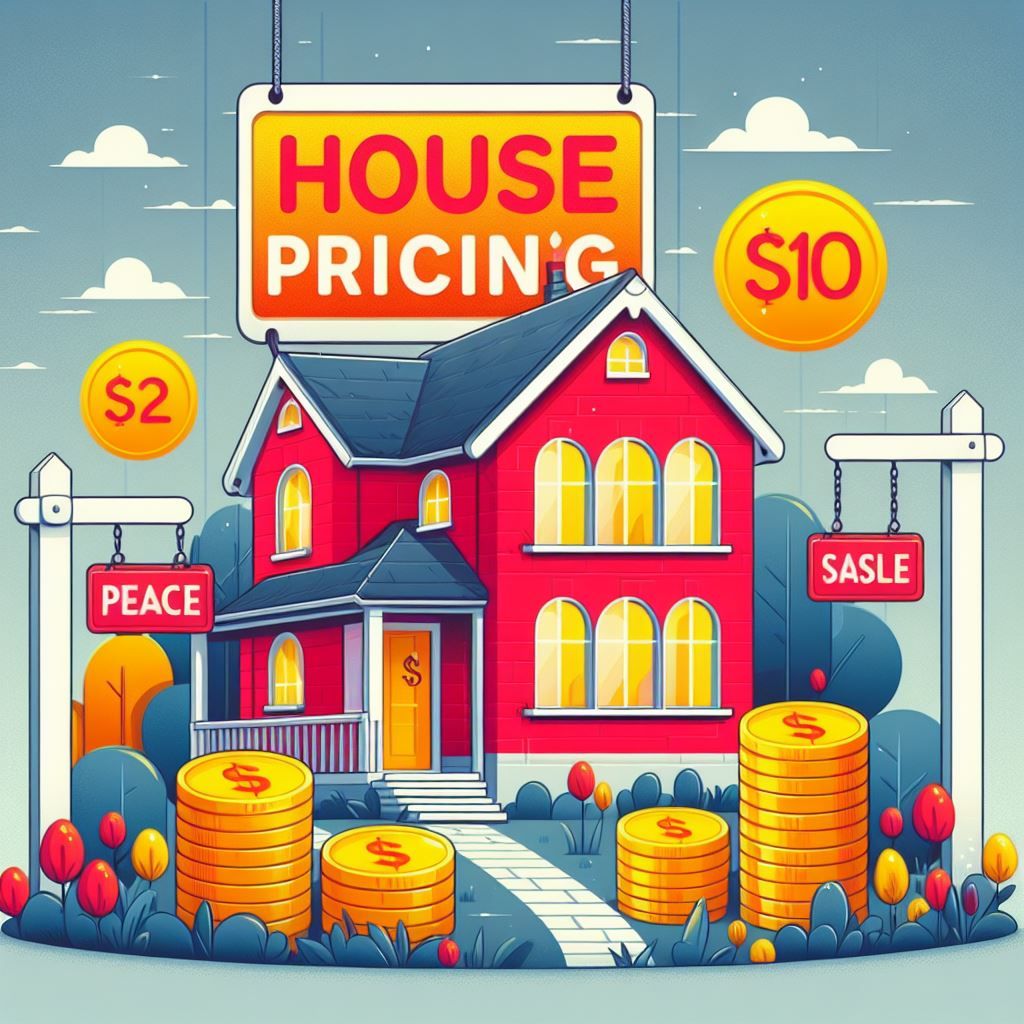

---
---

**BREIF OVERVIEW:**

---
---

This notebook demonstrates the interpretation of a blackbox model using the Ames Housing dataset. We explore both correlation and causation perspectives utilizing model interpretation tools such as SHAP and EconML. The dataset contains information on house prices and characteristics for homes sold in Ames, Iowa, spanning from 2006 to 2010.

**Key Points:**
- Initial exploration involves a linear regression model for building intuition.
- We then proceed to train a finely-tuned predictive machine learning model.
- SHAP is employed to understand feature-target correlations and identify the strongest predictors.
- Lastly, a separate causal model is trained using EconML, revealing features with direct causal effects on housing prices, moving beyond mere predictions to understanding causal relationships.

---

---
Installing Libraries and Preparing Data for Analysis

---

In [1]:
# Installing necessary libraries
!pip install shap
!pip install econml
!pip install shap


# Importing required libraries
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
from sklearn.datasets import fetch_openml
from econml.solutions.causal_analysis import CausalAnalysis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.45.0
    Uninstalling shap-0.45.0:
      Successfully uninstalled shap-0.45.0


---
Loading and Preprocessing the Dataset

---

In [2]:
# Step 1: Loading the dataset
ames_housing = fetch_openml(name="house_prices", as_frame=True)

# Step 2: Preprocessing the dataset
ames_df = ames_housing.data

# Checking the shape of the dataset
print(ames_df.shape)

# Preprocessing steps
Xy = (
    ames_df
    .assign(SalePrice=ames_housing.target)  # Adding target feature
    .set_index('Id')
    .loc[lambda df: df['MasVnrType'].notna()]  # Removing outliers with missing details
    .loc[lambda df: df['Electrical'].notna()]  # Removing outliers with missing electrical information
    .assign(
        AgeAtSale=lambda df: df['YrSold'].sub(df['YearBuilt']),  # Adding interpretable year columns
        YearsSinceRemodel=lambda df: df['YrSold'].sub(df['YearRemodAdd']).clip(lower=0),  # Clipping lower outliers

        HasDeck=lambda df: df['WoodDeckSF'].gt(0).map(int),
        HasPorch=lambda df:
        df[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']]
        .gt(0)
        .max(axis=1)
        .map(int),

        HasFireplace=lambda df: df['Fireplaces'].clip(upper=1).map(int),
        HasFence=lambda df: df['Fence'].notna().map(int)
    )

    # Dropping unnecessary columns
    .drop(
        columns=[
            'GarageYrBlt', 'YearBuilt', 'YrSold', 'YearRemodAdd',
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'FireplaceQu', 'Fireplaces',
            'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'PoolArea'
        ]
    )
    .assign(LotFrontage=lambda df: df['LotFrontage'].fillna(0))  # Filling missing values with 0
    .fillna('NA')  # Filling rest of missing values with 'NA' category
    .assign(Intercept=1)  # Adding constant column for OLS
)


The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


(1460, 80)


---
Explanation:

---

* The dataset is loaded using fetch_openml function with the name
* "house_prices" and is stored in the variable ames_housing.
* The data frame containing the dataset is extracted using .data attribute and stored in ames_df.
* The shape of the dataset is printed using print(ames_df.shape).
* Various preprocessing steps are performed on the dataset to prepare it for analysis and modeling:
* Adding the target feature 'SalePrice'.
* Setting the index to 'Id' column.
* Removing outliers by filtering rows with missing values in specific columns like 'MasVnrType' and 'Electrical'.
* Adding new columns such as 'AgeAtSale' and 'YearsSinceRemodel' to provide additional insights.
* Encoding categorical variables like presence of deck, porch, fireplace, and fence into binary indicators.
* Dropping unnecessary columns that are not relevant for analysis.
Handling missing values by filling missing values in 'LotFrontage' column with 0 and rest with 'NA'.

---

---

One-hot Encoding Categorical Variables

---

In [3]:
# Step 3: One-hot encoding categorical variables
categorical = list(
    Xy
    .apply(lambda series: series.dtype)
    .loc[lambda df: df.eq('object')]
    .index
) + ['MSSubClass']

X = Xy.drop(columns='SalePrice')
X_ohe = (
    X
    .pipe(pd.get_dummies, prefix_sep='_OHE_', columns=categorical, dtype='uint8')
)
y = Xy['SalePrice']


---

Explanation:

---

* Categorical variables are encoded using one-hot encoding to convert them into a format suitable for modeling.
* This process creates binary columns for each category in the categorical variables.

---

---

Training Linear Regression Model


---

In [4]:
# Train a linear regression using statsmodels
model = sm.OLS(y, X_ohe)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     59.41
Date:                Sat, 23 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:00:35   Log-Likelihood:                -16565.
No. Observations:                1451   AIC:                         3.362e+04
Df Residuals:                    1206   BIC:                         3.491e+04
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage                   9.1690     24.385      0.376      0.707     -38.674      57.012
OverallQual                6443.4507   1098.337      5.867      0.000    4288.587    8598.315
OverallCond                5761.3467    921.305      6.253      0.000    3953.808    7568.885
GrLivArea                    71.2724      3.926     18.155      0.000      63.570      78.975
BsmtFullBath               7808.0939   1862.581      4.192      0.000    4153.836    1.15e+04
BsmtHalfBath               2704.3964   3161.287      0.855      0.392   -3497.837    8906.630
FullBath                   4353.2284   2358.076      1.846      0.065    -273.159    8979.616
HalfBath                   1125.2313   2213.287      0.508      0.611   -3217.089    5467.552
BedroomAbvGr              -4678.0376   1473.399     -3.175      0.002   -7568.747   -1787.328
KitchenAbvGr              -1.089e+04   6648.976     -1.639      0.102   -2.39e+04    2150.473
TotRmsAbvGrd               1013.7051   1016.102      0.998      0.319    -979.818    3007.228
GarageCars                 8663.3405   1708.010      5.072      0.000    5312.340     1.2e+04
MiscVal                       9.0392      6.684      1.352      0.177      -4.074      22.153
MoSold                     -510.0946    260.244     -1.960      0.050   -1020.675       0.486
AgeAtSale                  -305.4555     85.143     -3.588      0.000    -472.501    -138.410
YearsSinceRemodel           -27.7465     58.392     -0.475      0.635    -142.308      86.815
HasDeck                    1621.8650   1585.671      1.023      0.307   -1489.115    4732.845
HasPorch                   1870.3246   1739.962      1.075      0.283   -1543.365    5284.014
HasFireplace               2375.0085   1818.079      1.306      0.192   -1191.941    5941.958
HasFence                  -5877.2263   2031.768     -2.893      0.004   -9863.419   -1891.033
Intercept                 -8887.1036   3683.133     -2.413      0.016   -1.61e+04   -1661.044
MSZoning_OHE_C (all)      -2.978e+04   8731.959     -3.411      0.001   -4.69e+04   -1.27e+04
MSZoning_OHE_FV            1.271e+04   6497.547      1.957      0.051     -33.757    2.55e+04
MSZoning_OHE_RH            4234.7895   6421.424      0.659      0.510   -8363.614    1.68e+04
MSZoning_OHE_RL            4630.5784   3487.791      1.328      0.185   -2212.233    1.15e+04
MSZoning_OHE_RM            -682.4301   3937.317     -0.173      0.862   -8407.183    7042.323
Street_OHE_Grvl           -8776.6589   6992.025     -1.255      0.210   -2.25e+04    4941.225
Street_OHE_Pave            -110.4448   6575.318     -0.017      0.987    -1.3e+04    1.28e+04
Alley_OHE_Grvl            -1810.1857   3604.374     -0.502      0.616   -8881.726    5261.355
Alley_OHE_NA              -4693.0936   2616.409     -1.794      0.073   -98

---
Explanation:

---

* A linear regression model is trained using the statsmodels library.
* This model will help us understand the relationship between the independent variables and the target variable ('SalePrice').

---

---

Splitting Data for Training and Testing

---

In [5]:
# Step 5: Splitting data into train and test sets
x_train_ohe, x_test_ohe, x_train, x_test, y_train, y_test = train_test_split(
    X_ohe, X, y, test_size=0.2, random_state=0
)


---

Explanation:

---

The dataset is split into training and testing sets to evaluate the performance of our models.

---

---
Training LightGBM Regression Model

---

In [6]:
# Step 6: Training a LightGBM regression model
est = LGBMRegressor()
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search = GridSearchCV(est, param_grid, n_jobs=-1)
search.fit(x_train_ohe, y_train)
fitted_model = search.best_estimator_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 1160, number of used features: 184
[LightGBM] [Info] Start training from score 181207.644828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

---

Explanation:

---

* bWe train a LightGBM regression model to predict house prices.
* Grid search is used to find the best combination of hyperparameters for the model.

---

---

Explaining Model Predictions with SHAP

---



In [7]:
# Step 7: Explaining model predictions using SHAP
background = shap.maskers.Independent(x_train_ohe, max_samples=1000)
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=X_ohe.columns
)
shap_values = explainer(x_test_ohe)


 99%|===================| 289/291 [00:18<00:00]       

---
Explanation:

---

* SHAP (SHapley Additive exPlanations) values are calculated to explain the model predictions.
* SHAP values help us understand the contribution of each feature to individual predictions.

---

---

Visualizing Feature Importance with SHAP

---

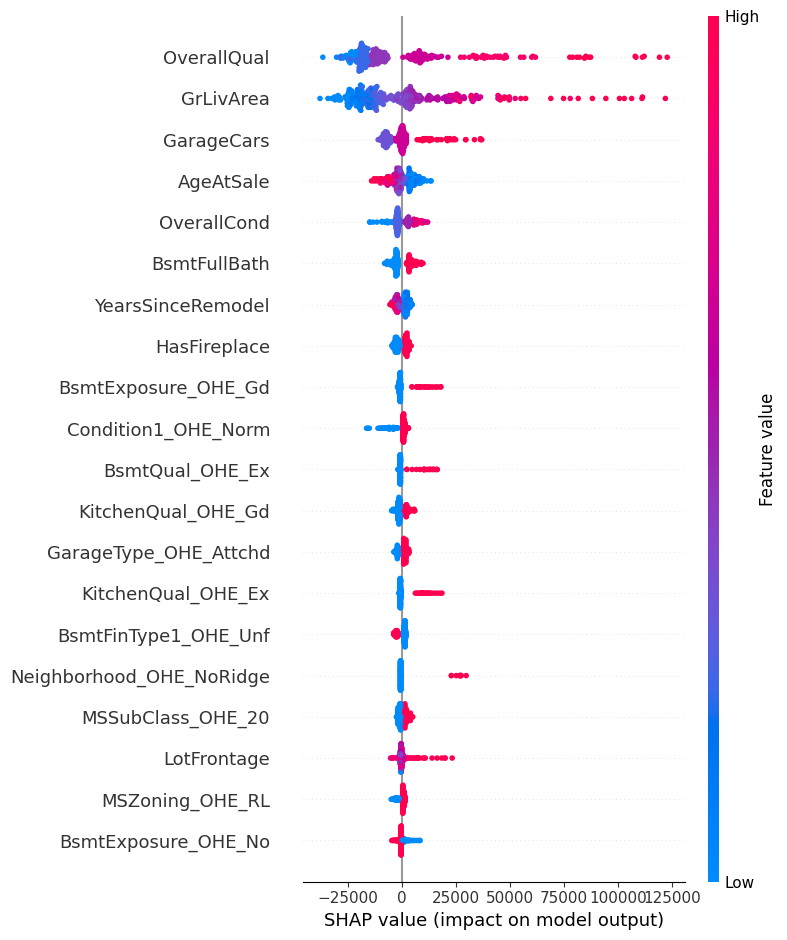

In [8]:
# Step 8: Visualizing feature importance
shap.summary_plot(shap_values, x_test_ohe)


---
Explanation:

---

* A summary plot is created to visualize the feature importance based on SHAP values.
* This plot helps us understand which features have the most significant impact on the model predictions.
* The above summary shows which features are most important for determining house prices.
* It tells us that houses that measure high in `overall quality`, `square footage`, and are also relatively new will have a higher housing price.

---


---

Causal Analysis

---

In [10]:
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)

# keep top k features for causal analysis
k = 5
sorted_features = feature_importance["features"]
top_k_features = list(sorted_features.values)[:5]

In [11]:
# Step 9: Causal Analysis
hetero_cols = ['AgeAtSale', 'MSZoning']
ca = CausalAnalysis(
    feature_inds=top_k_features + [
        'HasFireplace',
        'HasPorch',
        'HasDeck',
    ],
    categorical=categorical + ['HasFireplace', 'HasPorch', 'HasDeck', 'HasFence'],
    heterogeneity_inds=hetero_cols,
    classification=False,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
    random_state=123,
    upper_bound_on_cat_expansion=6
)
ca.fit(x_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 136
[LightGBM] [Info] Start training from score 182680.412678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


---
Explanation:

---
* Causal Analysis is performed to understand the causal relationship between features and the target variable.

* This analysis helps identify features that have a direct impact on house prices.

---

---

Conclusion and Error Bar Plot

---

In [12]:
# Step 10: Getting global causal effect ordered by causal importance (p-value)
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ_sorted = global_summ.sort_values(by="p_value")
global_summ_sorted

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
OverallQual,num,10103.815563,1675.148678,6.031593,1.623509e-09,6820.584485,13387.046640
GarageCars,num,13144.175268,2997.638920,4.384843,1.160696e-05,7268.910946,19019.439590
OverallCond,num,5645.799133,1457.913311,3.872520,1.077156e-04,2788.341551,8503.256716
GrLivArea,num,53.680237,16.896738,3.176959,1.488283e-03,20.563239,86.797235
HasFireplace,1v0,4391.217178,1510.683165,2.906776,3.651749e-03,1430.332582,7352.101775
HasPorch,1v0,4702.903044,2279.139024,2.063456,3.906933e-02,235.872642,9169.933446
AgeAtSale,num,-122.702114,110.966856,-1.105755,2.688327e-01,-340.193155,94.788926
HasDeck,1v0,1610.641783,1819.477098,0.885222,3.760367e-01,-1955.467800,5176.751367


<Figure size 1200x800 with 0 Axes>

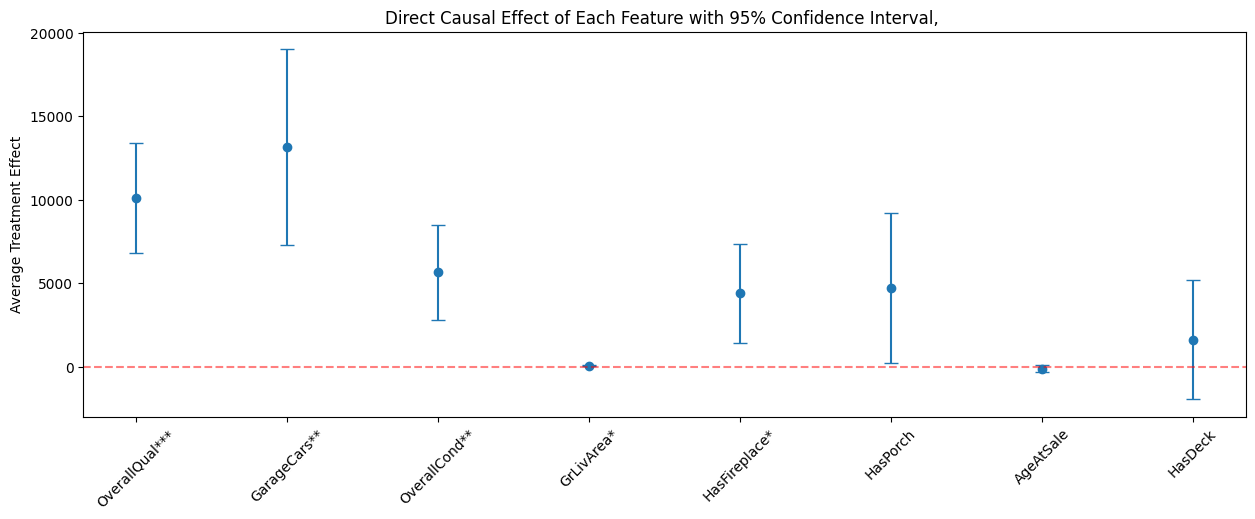

In [13]:
# Step 11: Plotting error bar for direct causal effect of each feature
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

plt.figure(figsize=(12, 8))
errorbar(global_summ_sorted)


---
Explanation

---

Based on the provided table, here are the inferences about the top 5 significant features based on their p-values:

**OverallQual (Overall Quality):**
- **Inference:** The overall quality of a property has a statistically significant impact on its price.
- **Statistical Significance:** The p-value associated with OverallQual is very low (1.623509e-09), indicating a highly significant effect on the target variable (price).

**GarageCars (Number of Cars Garage can Accommodate):**
- **Inference:** The capacity of the garage in terms of the number of cars it can accommodate significantly affects the property's price.
- **Statistical Significance:** The p-value for GarageCars is very low (1.160696e-05), indicating a strong statistical significance of this feature.

**OverallCond (Overall Condition):**
- **Inference:** The overall condition of a property has a noticeable impact on its price.
- **Statistical Significance:** The p-value associated with OverallCond is relatively low (1.077156e-04), indicating its statistical significance in determining the property's price.

**GrLivArea (Above Ground Living Area):**
- **Inference:** The size of the above ground living area significantly influences the property's price.
- **Statistical Significance:** GrLivArea has a relatively low p-value (1.488283e-03), indicating its statistical significance in determining the property's price.

**HasFireplace (Presence of Fireplace):**
- **Inference:** The presence of a fireplace can impact the property's price, though to a lesser extent compared to other features.
- **Statistical Significance:** While statistically significant, HasFireplace has a higher p-value (3.651749e-03) compared to the top features, indicating a slightly weaker association with the property's price compared to other features.

---
---

* The errorbar function plots an error bar for the direct causal effect of each feature.
* It calculates the lower and upper error bounds based on the confidence intervals and plots them along with the point estimates.
* We call the errorbar function with the sorted global causal effect data to generate the plot.
* We learn the Average Treatment Effect (ATE) for certain house characteristics (e.g., having a fireplace), assuming they are the treatment.
* The error bar above is ordered by feature importance.
* The summary table above is ordered by causal significance (p-value).
Notice they are not in the exact same order.
* For example, the second most predictive feature, GrLivArea (total square footage), is only the fourth most causally significant feature.

---
---

<h1 align="center"></h1>

---
---

# <center>**WORKED EXAMPLE 2**</center>

---

## <center>**Causal Analysis: Understanding Causal Relationships for Employee Attrition Prices**</center>

---

---


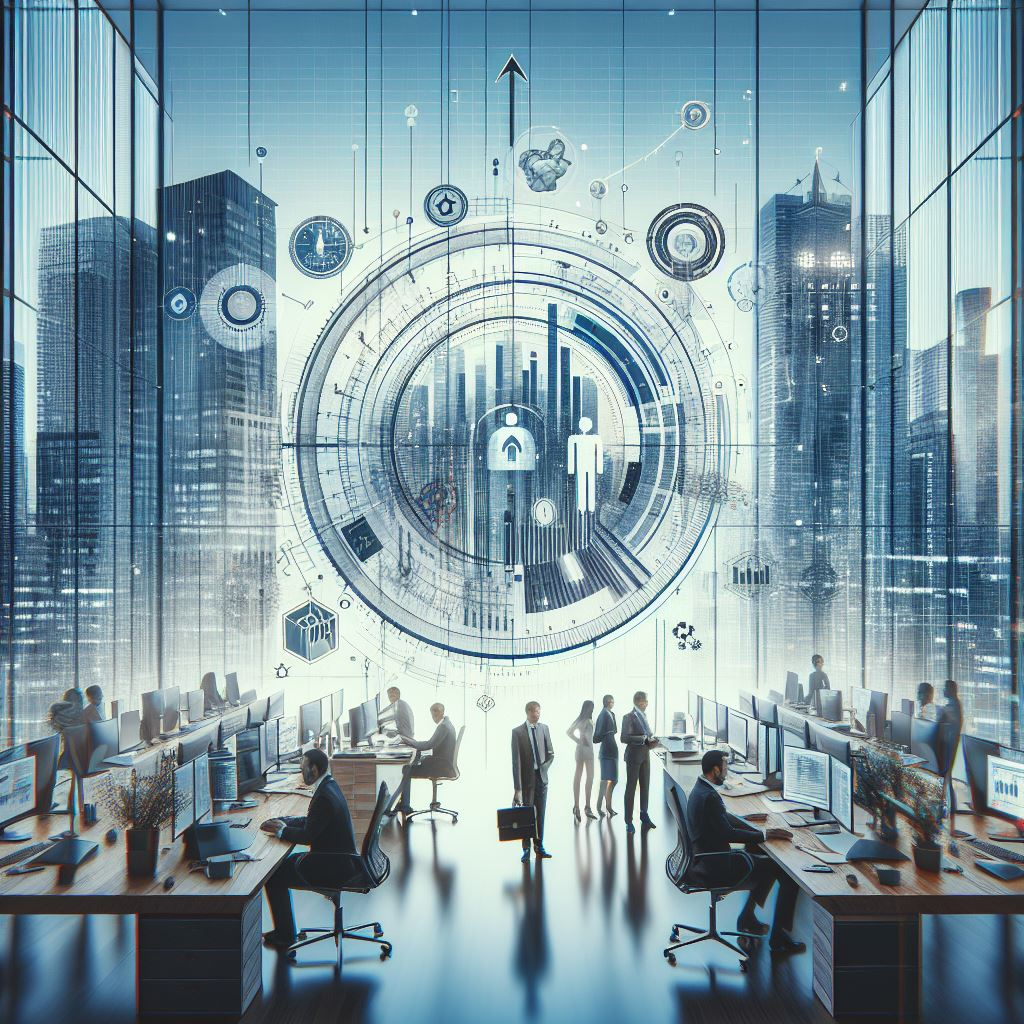

---
**BRIEF OVERVIEW**

---


This notebook uses the popular Kaggle Employee Attrition dataset to showcase how we can interpret a blackbox model from both correlation and causation perspectives. We leverage model interpretation tools like SHAP and EconML.

**Key Points:**
- We begin with a fine-tuned ML model to predict employee attrition.
- By learning the top important features, we aim to understand the correlations between features and the target variable.
- Additionally, we delve deeper into understanding which features cause employees to leave the company, moving beyond mere predictions.
- This causal interpretation can assist companies in making changes to minimize attrition rates.


---

---

Data Loading and Preparation

---

In [14]:
# Importing necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting display options for pandas
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 100)

# Loading dataset
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/EmployeeAttrition/Employee-Attrition.csv"
attritionData = pd.read_csv(file_url)
attritionData.head(5)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


---
Explanation:

---

* This section of code imports necessary libraries, sets display options for pandas, loads the dataset from a URL into a pandas DataFrame, and displays the first five rows of the dataset.

---

---

Data Preprocessing

---


In [15]:
# Dropping irrelevant columns
attritionData = attritionData.drop(["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"], axis=1)

# Changing unit of income related variables
attritionData[["MonthlyIncome/1K", "MonthlyRate/1K"]] = (
    attritionData[["MonthlyIncome", "MonthlyRate"]] / 1000
)
attritionData = attritionData.drop(["MonthlyIncome", "MonthlyRate"], axis=1)

# Converting target variable from string to numerical values
target_map = {"Yes": 1, "No": 0}
attritionData["Attrition_numerical"] = attritionData["Attrition"].apply(
    lambda x: target_map[x]
)
target = attritionData["Attrition_numerical"]

attritionXData = attritionData.drop(["Attrition_numerical", "Attrition"], axis=1)


---

Explanation:

---
* In this section, irrelevant columns are dropped, and units of income-related variables are changed.
* The target variable 'Attrition' is converted from strings ("Yes" and "No") to numerical values (1 and 0), and the target column is separated from the features.

---

---
Data Splitting

---

In [16]:
# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    attritionXData, target, test_size=0.2, random_state=0, stratify=target
)


---
Explanation:

---

* This part of the code splits the dataset into training and testing sets using the train_test_split function from scikit-learn.

---

---

Preprocessing Pipelines

---

In [18]:
categorical = []
for col, value in attritionXData.items():
    if value.dtype == "object":
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attritionXData.columns.difference(categorical)

In [19]:
from sklearn.compose import ColumnTransformer

# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="error", drop="first")),
    ]
)

transformations = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical),
        ("cat", categorical_transformer, categorical),
    ]
)


---

Explanation:

---
* This part of the code creates preprocessing pipelines for numeric and categorical data.
* It handles missing values by imputing them with median values for numeric data and a constant value for categorical data.
* One-hot encoding is used for categorical variables. These pipelines are then combined into a single ColumnTransformer.

---

---
Model Building and Training

---

In [20]:
# Creating a pipeline with preprocessing and LightGBM classifier
clf = Pipeline(
    steps=[("preprocessor", transformations), ("classifier", LGBMClassifier())]
)

# Performing grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": [0.1, 0.05, 0.01],
    "classifier__max_depth": [3, 5, 10],
}
search = GridSearchCV(clf, param_grid, n_jobs=-1)

search.fit(x_train, y_train)
search.best_params_


[LightGBM] [Info] Number of positive: 190, number of negative: 986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161565 -> initscore=-1.646632
[LightGBM] [Info] Start training from score -1.646632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3}

---

Explanation:

---
* This section creates a pipeline that includes data preprocessing and a LightGBM classifier.
* Grid search is performed to find the best hyperparameters for the classifier using cross-validation.

----

---

Model Interpretation with SHAP


---

In [21]:
# get the fitted model and transformer
fitted_model = search.best_estimator_["classifier"]
fitted_transformer = search.best_estimator_["preprocessor"]
# get the feature name after featurization
column_names = numerical.tolist()
column_names += (
    search.best_estimator_["preprocessor"]
    .transformers_[1][1]
    .steps[1][1]
    .get_feature_names_out(categorical)
    .tolist()
)

Passing 1176 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


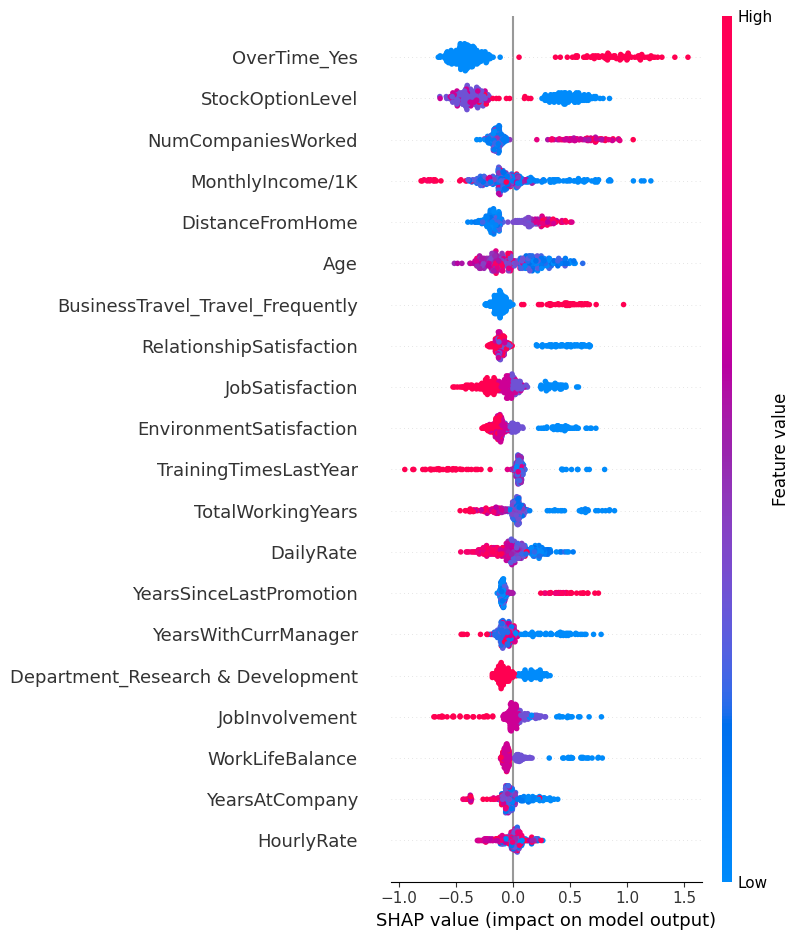

In [22]:
# Computing SHAP values for model interpretation
import shap

background = shap.maskers.Independent(
    fitted_transformer.transform(x_train), max_samples=2000
)
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=column_names
)
shap_values = explainer(fitted_transformer.transform(x_test))

# Plotting the feature importance using SHAP summary plot
shap.summary_plot(shap_values, fitted_transformer.transform(x_test))


---

Explanation:

---

- The summary plot shows the most important features affecting whether employees leave the company.
- Among the top 5 important features:
  - Employees who work overtime frequently are more likely to leave.
  - Employees who change jobs frequently are more likely to leave.
  - Employees who live far from their workplace are more likely to leave.
  - Employees with higher income are less likely to leave.
  - Employees with stock options are less likely to leave.
- However, these features might not directly cause employees to leave; there could be hidden variables that influence both these features and the outcome.
- For example, an inefficient collaboration environment might lead employees to work overtime and leave the company, rather than working overtime itself being the direct cause.
- To accurately identify the direct reasons and make appropriate improvements, we need to train a model that controls for all possible hidden variables (confounders) and learns the direct causal effect of each feature.
- This is what the causal interpretation tool aims to achieve.
- In the next section, we'll delve into the causal relationship for the top 5 important features to understand their direct impact.

---

---
Causal Analysis

---

In [23]:
classification = True
k = 5
# get top feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)
top_features = feature_importance.iloc[:k]["features"]
# extract the raw feature name for top features
top_features = [i.split("_")[0] for i in top_features]

In [24]:
from econml.solutions.causal_analysis import CausalAnalysis

ca = CausalAnalysis(
    top_features,
    categorical,
    heterogeneity_inds=None,
    classification=True,
    nuisance_models="automl",
    heterogeneity_model="forest",
    n_jobs=-1,
    random_state=123,
)
ca.fit(x_train, y_train.values)

[LightGBM] [Info] Number of positive: 127, number of negative: 657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 784, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161990 -> initscore=-1.643497
[LightGBM] [Info] Start training from score -1.643497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [25]:
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
OverTime,YesvNo,0.215724,0.023250,9.278618,1.716911e-20,0.170155,0.261292
StockOptionLevel,num,-0.016576,0.023420,-0.707765,4.790912e-01,-0.062478,0.029326
NumCompaniesWorked,num,0.024649,0.011108,2.219089,2.648070e-02,0.002878,0.046420
MonthlyIncome/1K,num,-0.011102,0.013316,-0.833729,4.044340e-01,-0.037201,0.014997
DistanceFromHome,num,0.004332,0.002366,1.831227,6.706661e-02,-0.000305,0.008969


---
Explanation:

---

- **OverTime (Yes vs. No)**:
  - **Statistical Significance**: Highly significant (p-value: 1.717e-20).
  - **Explanation**: Employees who work overtime are estimated to be significantly more likely to leave the company compared to those who don't work overtime.

- **StockOptionLevel (numerical)**:
  - **Statistical Significance**: Not significant (p-value: 0.479).
  - **Explanation**: The stock option level does not appear to have a statistically significant effect on the likelihood of attrition.

- **NumCompaniesWorked (numerical)**:
  - **Statistical Significance**: Significant (p-value: 0.027).
  - **Explanation**: For each additional company an employee has worked for, there's a statistically significant increase in the likelihood of attrition.

- **MonthlyIncome/1K (numerical)**:
  - **Statistical Significance**: Not significant (p-value: 0.404).
  - **Explanation**: Monthly income does not seem to have a statistically significant effect on the likelihood of attrition.

- **DistanceFromHome (numerical)**:
  - **Statistical Significance**: Marginally not significant (p-value: 0.067).
  - **Explanation**: While there's a slight positive association between distance from home and attrition likelihood, it's not statistically significant at the conventional 0.05 significance level.


---

In [26]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")
    plt.show()

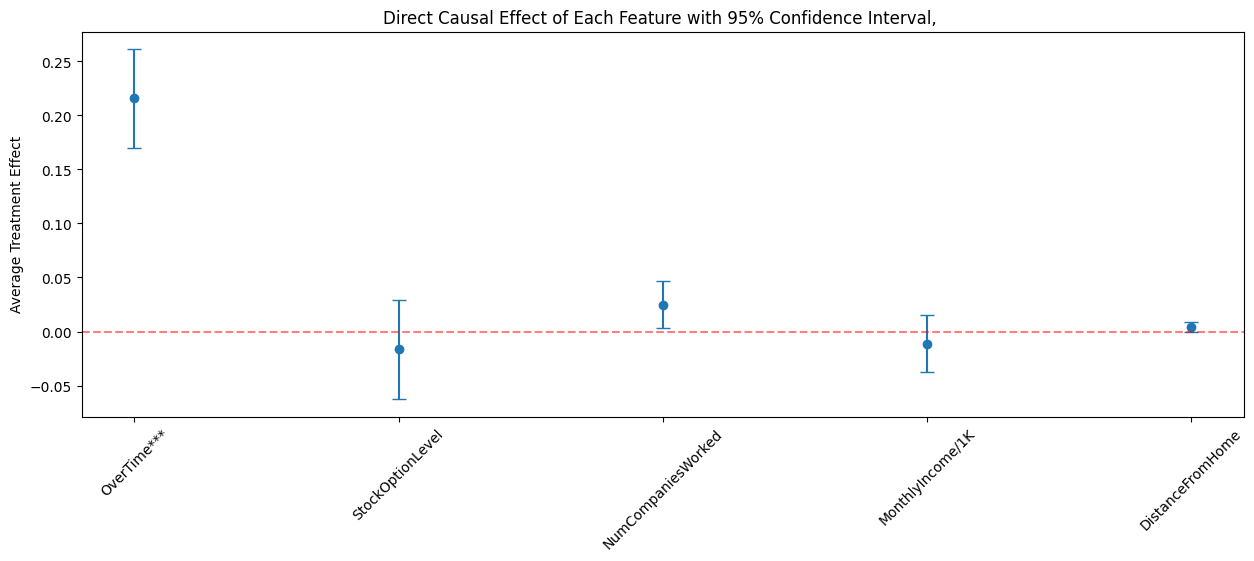

In [27]:
errorbar(global_summ)

---

Explanation:

---

In the causal analysis, we examine the Average Treatment Effect (ATE) for each of the top 5 important features, considering them as treatments.

- From the summary table and error bar plot, we observe that the causal effect directions align with the correlation directions we identified earlier.
- However, for features like StockOptionLevel or MonthlyIncome/1K, although they are strong predictors of whether employees will leave, we are less confident in stating that they directly cause employees to leave.
- This insight is highly valuable for managers planning to reduce employee attrition rates. Improving work-life balance or providing additional support for employees living far from the company might be more effective strategies than simply raising their salary or offering stock options.

By understanding the direct causal effects, managers can make more informed decisions to address employee attrition effectively.

---

---
---
## **REFERENCES**
---
---

- https://www.microsoft.com/en-us/research/project/econml/
- https://youtu.be/XwYHUv2nH34
- https://www.datacamp.com/tutorial/intro-to-causal-ai-using-the-dowhy-library-in-python
- https://analyticsindiamag.com/a-complete-guide-to-causal-inference-in-python/
- https://www.sciencedirect.com/topics/social-sciences/causal-inference#:~:text=Causal%20inference%20refers%20to%20an,causal%20conclusions%20based%20on%20data.
- https://medium.com/data-science-at-microsoft/causal-inference-part-1-of-3-understanding-the-fundamentals-816f4723e54a
- https://en.wikipedia.org/wiki/Causal_inference



---
---
**Copyright**
---
---
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.